# 簡介

* 目標
    * Search Team重組
    * 比較多個Agent和單一Agent的回覆準確度
    * 讓Retriever可以對預處理資料做RAG
    * Supevisor不再需要幫忙審視每個團隊各自的工作成果，只需負責工作調度
* Search Team 重組
    * 將Crawler的工作簡化為一個tool
    * Summarizer先讀取網頁再判斷接著要總結內文還是丟連結
    * Summarizer全部做完後再將總結內文回報給Supervisor

# API Keys & LLM Models

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

In [4]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")
llm = ChatOpenAI(model="gpt-4o-mini")

# Create Tools

## Search

In [5]:
import re
import pdfplumber
from io import BytesIO
import requests
from bs4 import BeautifulSoup
from langchain_core.tools import tool
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

@tool
def none() -> None:
    """Return None."""
    return None

@tool
def website_info_retriever(query: str) -> str:
    """Perform RAG retrieval on the website dataset."""
    vectorstore = Chroma(
        embedding_function=OpenAIEmbeddings(),
        collection_name="ncu_office_websites",
        persist_directory="./Parse Websites v2/ncu_office_websites"
    )
    website_retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})
    docs = website_retriever.invoke(query)
    result = ""
    for i in range(len(docs)):
        link = docs[i].metadata.get("link")
        page_content = docs[i].page_content

        print("link: ", link)
        print("page_content: ", page_content)
        result += "link: " + link + "\n" + page_content + "\n"
    return result


@tool
def website_crawler(link: str, cur_title: str) -> list[dict]:
    """Takes url of a website and reads the HTML content of the website and then extracts all the links on that website."""
    extract_link = re.search(r'(https?://[^\]]+)', link) # 使用正則表達式擷取連結
    url = extract_link.group(1) if extract_link else None
    
    try: # 發送HTTP請求，獲取網頁內容
        response = requests.get(url, timeout=1)
        encoding = response.apparent_encoding
        response.encoding = encoding
    except requests.exceptions.RequestException as e:
        print(f"無法獲取 [{cur_title}]: [{url}] 。錯誤: {e}")
        return f"無法獲取 [{cur_title}]: [{url}] 。錯誤: {e}"

    websites = []
    result = ""
    if response.status_code == 200: # 確保請求成功
        page_content = response.text # 獲取頁面的HTML內容
        soup = BeautifulSoup(page_content, 'html.parser')
        links = soup.find_all('a') # 找到所有的<a>標籤，iframe有問題

        # 提取每個<a>標籤的title和href屬性，並組織成列表
        for link in links:
            title = link.get_text(strip=True)  # 提取連結的文本作為標題
            if title == '':  # 若標題為空，則跳過
                continue

            href = link.get('href') # 提取連結的href屬性
            if href: # 確保href存在
                final_url = ""
                if 'http' in href:  # 如果href是完整的連結，直接使用
                    final_url = href
                else:
                    postclitics = ['html', 'htm', 'asp', 'php', 'pdf', 'PDF']  # 定義可能的後綴類型
                    url_postclitic = next((p for p in postclitics if p in url), "")  # 從url中找到匹配的後綴
                    psotclitic = any(p in href for p in postclitics)  # 檢查href中是否有後綴

                    # 如果href和url都有後綴，從url中去除最後的部分，否則使用原始url
                    temp_url = re.sub(rf'/[^/]+\.{url_postclitic}$', '', url) if psotclitic and url_postclitic else url
                    href = '/' + href.lstrip('/')  # 確保href以單個斜杠開頭
                    if temp_url.split('/')[-1] == href.split('/')[1]: # 處理相對連結
                        temp_url = '/'.join(temp_url.split('/')[:-1])
                    
                    final_url = temp_url + href

                try: # 檢查組合後的連結是否有效
                    test_response = requests.get(final_url, timeout=1)
                    encoding = test_response.apparent_encoding
                    test_response.encoding = encoding
                    if test_response.status_code == 200:
                        # print(f"成功獲取[{title}]: [{final_url}] ，加入資料中。")
                        websites.append({'title': title, 'link': final_url})  # 將完整連結加入資料中
                    # else:
                        # print(f"無法獲取[{title}]: [{final_url}] ，不加入資料中。HTTP 狀態碼: {test_response.status_code}")
                except requests.exceptions.RequestException as e:
                    print(f"無法獲取[{title}]: [{final_url}] ，不加入資料中。錯誤: {e}")

        print(f"成功獲取 [{cur_title}]: [{url}] 中共{len(websites)}個連結。")
        result = "\n".join([f"[{item['title']}]: [{item['link']}]" for item in websites])
    else:
        # print(f"無法獲取[{cur_title}]: [{url}] 。HTTP 狀態碼: {response.status_code}")
        return f"無法獲取 [{cur_title}]: [{url}] 。HTTP 狀態碼: {response.status_code}"
    
    return result

@tool
def website_reader(url: str) -> str:
    """Read the content of a website."""
    try: 
        response = requests.get(url)
        encoding = response.apparent_encoding
        response.encoding = encoding
    except requests.exceptions.RequestException as e:
        print(f"無法獲取 [{url}] 。錯誤: {e}")
        return f"無法獲取 [{url}] 。錯誤: {e}"
    
    soup = BeautifulSoup(response.text, 'html.parser')
    content = soup.get_text()
    print(f"成功讀取 [{url}] 並總結。")

    cleaned_content = "\n".join([line for line in content.split("\n") if line.strip()])
    return cleaned_content

@tool
def pdf_reader(url: str) -> str:
    """Read the content of a PDF file."""
    try: 
        response = requests.get(url)
        encoding = response.apparent_encoding
        response.encoding = encoding
    except requests.exceptions.RequestException as e:
        print(f"無法獲取 [{url}] 。錯誤: {e}")
        return f"無法獲取 [{url}] 。錯誤: {e}"

    # 檢查是否成功下載
    if response.status_code == 200:
        # 使用 BytesIO 將下載的內容轉為二進制流
        pdf_file = BytesIO(response.content)
        
        with pdfplumber.open(pdf_file) as pdf:
            pdf_text = ""
            for page in pdf.pages:
                pdf_text += page.extract_text()
                
        print(f"成功讀取 [{url}] 並總結。")
        return pdf_text
    else:
        print(f"下載失敗，HTTP 狀態碼: {response.status_code}")
        return f"下載失敗，HTTP 狀態碼: {response.status_code}"

## Selenium Controller

In [6]:
from utils.selenium_controller import SeleniumController

selenium_controller = SeleniumController()
account = "111502026"
password = "Georgeshiue1107"

@tool 
def create_browser(user_id: str) -> str:
    """Create a new browser session."""
    result = selenium_controller.create_browser(user_id)
    return result

@tool
def screen_shot(user_id: str, file_path: str) -> str:
    """Take a screenshot of the current page and save it to the file path."""
    result = selenium_controller.screen_shot(user_id, file_path)
    return result

@tool
def navigate(user_id: str, url: str) -> str:
    """Navigate to the specified URL."""
    result = selenium_controller.navigate(user_id, url)
    return result

@tool
def get_html_content(user_id: str) -> str:
    """Get the HTML content of the current page."""
    result = selenium_controller.get_content(user_id)
    return result

@tool
def input_text_with_label(user_id: str, label_text: str, text: str, privacy: str = "None") -> str:
    """
    Inputs text into the input element specified by the text of the label for the given user_id.
    Replace the text argument with the external information when the privacy parameter is not "None".
    """
    if privacy == "Account":
        text = account
    if privacy == "Password":
        text = password
    result = selenium_controller.input_text_with_label(user_id, label_text, text, privacy)
    return result

@tool
def input_text_with_name(user_id: str, name: str, text: str, privacy: str = "None") -> str:
    """
    Inputs text into the input element specified by the text of the label for the given user_id.
    Replace the text argument with the external information when the privacy parameter is not "None".
    """
    if privacy == "Account":
        text = account
    if privacy == "Password":
        text = password
        print("password:", text)
    result = selenium_controller.input_text_with_name(user_id, name, text, privacy)
    return result

@tool
def click_button_with_text(user_id: str, text: str) -> str:
    """Clicks the button specified by the Text for the given user_id."""
    result = selenium_controller.click_button_with_text(user_id, text)
    return result

@tool
def click_input_with_label(user_id: str, label_text: str) -> str:
    """
    Clicks the input specified by the text of the label for the given user_id.
    Use case: clicking the checkbox with label.
    """
    result = selenium_controller.click_input_with_label(user_id, label_text)
    return result

@tool
def click_input_with_id(user_id: str, id: str) -> str:
    """
    Clicks the input specified by the ID for the given user_id.
    Use case: clicking the input box without label.
    """
    result = selenium_controller.click_input_with_id(user_id, id)
    return result

@tool
def select_dropdown_option(user_id: str, option_text: str) -> str:
    """Selects the dropdown option specified by its text for the given user_id."""
    result = selenium_controller.select_dropdown_option(user_id, option_text)
    return result

@tool
def click_span_with_aria_label(user_id: str, aria_label: str, index: str = "1") -> str:
    """
    Clicks the span specified by the Aria Label for the given user_id.
    Use case: clicking date inside the calendar.
    index: the index of the span element to click, set index value based on user's instruction such as "第{index}個".
    """
    result = selenium_controller.click_span_with_aria_label(user_id, aria_label, int(index))
    return result

@tool
def upload_file_with_id(user_id: str, id: str, file_path: str) -> str:
    """Uploads a file to the element specified by the ID for the given user_id."""
    selenium_controller.scroll_to_middle(user_id)
    result = selenium_controller.upload_file_with_id(user_id, id, file_path)
    return result

Error initializing Docker client: Error while fetching server API version: (2, 'CreateFile', '系統找不到指定的檔案。')


## Define All Tools

In [7]:
all_tools = {
    'none': none, 
    'website_info_retriever': website_info_retriever, 
    'website_crawler': website_crawler, 
    'website_reader': website_reader, 
    'pdf_reader': pdf_reader,
    'create_browser': create_browser,
    'screen_shot': screen_shot,
    'navigate': navigate,
    'input_text_with_label': input_text_with_label,
    'get_html_content': get_html_content,
    'input_text_with_name': input_text_with_name,
    'click_button_with_text': click_button_with_text,
    'click_input_with_label': click_input_with_label,
    'select_dropdown_option': select_dropdown_option,
    'click_input_with_id': click_input_with_id,
    'click_span_with_aria_label': click_span_with_aria_label,
    'upload_file_with_id': upload_file_with_id
}

# Define Agent Basic Settings

## Read Agent Parameter (yaml)

In [8]:
import yaml

# !注意yaml檔案版本
with open('Agents_v4.yaml', 'r', encoding="utf-8") as file:
    agents_parameter = yaml.safe_load(file)

## Define Agent Sate

In [9]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langchain_core.prompts import ChatPromptTemplate

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    user_id: str
    next: str

# 定義modify_state_messages才可以讓agent帶有prompt模板
basic_system_message = agents_parameter["workflow_basic"]["basic_system_message"]
def modify_state_messages(state, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", basic_system_message), # basic_system_message裡有{tool_names}和{system_message}兩個placeholder
            ("placeholder", "{messages}"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt.invoke({"messages": state["messages"]})

## Define Agent Node

In [10]:
from langchain_core.messages import HumanMessage

def pipeline_agent_node(state, agent, name):
    state["messages"][-1].content = "user_id: " + state["user_id"] + "\n" + state["messages"][-1].content
    result = agent.invoke(state)
    # print("messages: ")
    # print(state["messages"])
    # print("user_id: " + state["user_id"])
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)], "user_id": state["user_id"]}

def agent_node(state, agent, name):
    result = agent.invoke(state)
    # print(f"Result type: {type(result)}")
    # print(f"Result: {result}")
    # messages = result["messages"]
    # for message in messages:
    #     print(f"{type(message)}:")
    #     print(f"{message.content}")
    #     print()
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

# Workflow Graph

## Create Workflow Agents

In [11]:
import functools
from langgraph.prebuilt import create_react_agent

# Retriever
tools = [all_tools[name] for name in agents_parameter['retriever']['tools']]
system_message = agents_parameter['retriever']['system_message']
retriever = create_react_agent(llm, tools=tools, state_modifier=functools.partial(modify_state_messages, tools=tools, system_message=system_message))
retriever_node = functools.partial(agent_node, agent=retriever, name="Retriever")

# Summarizer
tools = [all_tools[name] for name in agents_parameter['summarizer']['tools']]
system_message = agents_parameter['summarizer']['system_message']
summarizer = create_react_agent(llm, tools=tools, state_modifier=functools.partial(modify_state_messages, tools=tools, system_message=system_message))
summarizer_node = functools.partial(agent_node, agent=summarizer, name="Summarizer")

## Create Supervisor

In [12]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel
from typing import Literal

members = ["Retriever", "Summarizer"]
options = ["FINISH"] + members

class routeResponse(BaseModel):
    next: Literal["Retriever", "Summarizer", "FINISH"]

system_prompt = agents_parameter['supervisor']['system_prompt']
decide_logic = agents_parameter['supervisor']['decide_logic']
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        ("system", decide_logic),
    ]
).partial(options=str(options), members=", ".join(members))

def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

## Define Retriever Graph

In [13]:
from langgraph.graph import StateGraph
from langgraph.graph import END, START
from langgraph.checkpoint.memory import MemorySaver

retriever_ = StateGraph(AgentState)
retriever_.add_node("Retriever", retriever_node)

retriever_.add_edge(START, "Retriever")
retriever_.add_edge("Retriever", END)

retriever_memory = MemorySaver()
retriever_graph = retriever_.compile(checkpointer=retriever_memory)

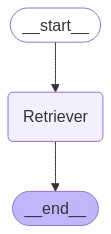

In [14]:
from IPython.display import Image, display

display(Image(retriever_graph.get_graph(xray=1).draw_mermaid_png()))

### Invoke

In [15]:
# Invoke service graph
# 請給我教務處的最新消息
# 請給我教務長的姓名
# 請簡介111教務章則的內容
# https://pdc.adm.ncu.edu.tw 請總結最新消息
# https://pdc.adm.ncu.edu.tw 請總結111教務章則內容
# https://pdc.adm.ncu.edu.tw/register/rule/rule_01.pdf 請總結此文件內容
# query = input()
# input_messages = {"messages": [HumanMessage(content=query)]}
# thread_id = "123"
# config = {
#     "recursion_limit": 50, # agent彼此間的最大交互次數
#     "configurable": {
#         "thread_id": "retriever" + thread_id # 用來存取記憶的id
#     }
# }

# for chunk in retriever_graph.stream(input=input_messages, config=config, subgraphs=True, stream_mode="values"):
#     chunk[1]["messages"][-1].pretty_print()

## Define Summarizer Graph

In [16]:
from langgraph.graph import StateGraph
from langgraph.graph import END, START
from langgraph.checkpoint.memory import MemorySaver

summarizer_ = StateGraph(AgentState)
summarizer_.add_node("Summarizer", summarizer_node)

summarizer_.add_edge(START, "Summarizer")
summarizer_.add_edge("Summarizer", END)

summarizer_memory = MemorySaver()
summarizer_graph = summarizer_.compile(checkpointer=retriever_memory)

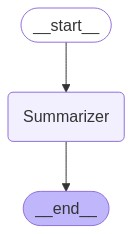

In [17]:
from IPython.display import Image, display

display(Image(summarizer_graph.get_graph(xray=1).draw_mermaid_png()))

### Invoke

In [18]:
# Invoke service graph
# 請給我教務處的最新消息
# 請給我教務長的姓名
# 請簡介111教務章則的內容
# https://pdc.adm.ncu.edu.tw 請總結最新消息
# https://pdc.adm.ncu.edu.tw 請總結111教務章則內容
# https://pdc.adm.ncu.edu.tw/register/rule/rule_01.pdf 請總結此文件內容
# query = input()
# input_messages = {"messages": [HumanMessage(content=query)]}
# thread_id = "123"
# config = {
#     "recursion_limit": 50, # agent彼此間的最大交互次數
#     "configurable": {
#         "thread_id": "summarizer" + thread_id # 用來存取記憶的id
#     }
# }

# for chunk in summarizer_graph.stream(input=input_messages, config=config, subgraphs=True, stream_mode="values"):
#     chunk[1]["messages"][-1].pretty_print()
    # agents = ["Retriever", "Search Team", "Supervisor", "Service"]
    # current_agent = None
    # message = None

    # for agent in agents:
    #     if agent in s[1]:
    #         current_agent = agent
    #         if agent == "Supervisor":
    #             message = s[1][agent].get('next', [])
    #         else:
    #             messages = s[1][agent].get('messages', [])
    #             message = messages[-1].content if messages else None
    #         break
    
    # if message:
    #     print(current_agent + ": " + message)
    #     print("----")

## Define Workflow Graph

In [19]:
from langgraph.graph import StateGraph
from langgraph.graph import END, START
from langgraph.checkpoint.memory import MemorySaver

thread_id = "123456789" #!!! Thread id 要各自分開!!!!!

def call_retriever_graph(state: AgentState) -> AgentState:
    retriever_graph_input = {"messages": state["messages"][-1:]} # 只傳入狀態消息中的最後一則訊息
    print()
    print("retreirver_graph_input: ")
    print(retriever_graph_input)
    config={
        "recursion_limit": 10, # agent彼此間的最大交互次數
        "configurable": {
            "thread_id": "retriever" + thread_id # 用來存取記憶的id
        }
    }
    print("Thread id: ", "retriever" + thread_id)
    retriever_graph_output = retriever_graph.invoke(retriever_graph_input, config=config)
    print("output: ") 
    print(retriever_graph_output["messages"])
    print()
    return {"messages": retriever_graph_output["messages"][-1:]} # 回傳狀態中的最後一則訊息

def call_summarizer_graph(state: AgentState) -> AgentState:
    summarizer_graph_input = {"messages": state["messages"][-2:]} # 只傳入狀態消息中的最後兩則訊息
    print()
    print("summarizer_graph_input: ")
    print(summarizer_graph_input)
    config={
        "recursion_limit": 50, # agent彼此間的最大交互次數
        "configurable": {
            "thread_id": "summarizer" + thread_id # 用來存取記憶的id
        }
    }
    print("Thread id: ", "summarizer" + thread_id)
    summarizer_graph_output = summarizer_graph.invoke(summarizer_graph_input, config=config)
    print("output: ")
    print(summarizer_graph_output["messages"])
    print()
    return {"messages": summarizer_graph_output["messages"][-1:]} # 回傳狀態中的最後一則訊息


workflow = StateGraph(AgentState)
workflow.add_node("Retriever", call_retriever_graph)
workflow.add_node("Summarizer", call_summarizer_graph)
workflow.add_node("Supervisor", supervisor_agent)

for member in members:
    workflow.add_edge(member, "Supervisor")
# The supervisor populates the "next" field in the graph state which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], conditional_map)
workflow.add_edge(START, "Supervisor")

workflow_memory = MemorySaver() # 記錄整個graph的記憶
workflow_graph = workflow.compile(checkpointer=workflow_memory)

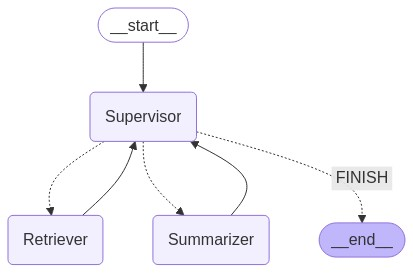

In [20]:
from IPython.display import Image, display

display(Image(workflow_graph.get_graph(xray=1).draw_mermaid_png()))

### Invoke

In [21]:
# 請給我教務處的最新消息
# 請給我教務長的姓名
# 請總結111教務章則的內容
# query = input()
# input_messages = {"messages": [HumanMessage(content=query)]}
# thread_id = "456"
# config = {
#     "recursion_limit": 100, # agent彼此間的最大交互次數
#     "configurable": {
#         "thread_id": "workflow" + thread_id # 用來存取記憶的id
#     }
# }

# for chunk in workflow_graph.stream(input=input_messages, config=config, subgraphs=True, stream_mode="values"):
#     chunk[1]["messages"][-1].pretty_print()

# Service Graph

## Create Service

In [22]:
import functools
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import create_react_agent

# !定義modify_state_messages才可以讓agent帶有prompt模板
def modify_service_state_messages(state: AgentState, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_message),
            ("placeholder", "{messages}"),
        ]
    )
    return prompt.invoke({"messages": state["messages"]})

system_message = agents_parameter['service']['system_message']
service = create_react_agent(llm, tools = [none], state_modifier = functools.partial(modify_service_state_messages, system_message=system_message))
service_node = functools.partial(agent_node, agent=service, name="Service")

## Define Service Graph

In [23]:
from langgraph.graph import StateGraph
from langgraph.graph import END, START
from langgraph.checkpoint.memory import MemorySaver
from typing import Literal

def start_end_router(state) -> Literal["Start", "End"]:
    messages = state["messages"]
    last_message = messages[-1]

    if "START Workflow" in last_message.content:
        return "Start"
    
    return "End"

def call_workflow_graph(state: AgentState) -> AgentState:
    workflow_graph_input = {"messages": state["messages"][-2:]}
    print()
    print("workflow_graph_input: ")
    print(workflow_graph_input)
    config={
        "recursion_limit": 100, # agent彼此間的最大交互次數
        "configurable": {
            "thread_id": "workflow" + thread_id # 用來存取記憶的id
        }
    }
    print("Thread id: ", "workflow" + thread_id)
    workflow_graph_output = workflow_graph.invoke(workflow_graph_input, config=config)
    print("output: ")
    print(workflow_graph_output["messages"])
    print()
    return {"messages": workflow_graph_output["messages"][-1:]}

service_ = StateGraph(AgentState)
service_.add_node("Service", service_node)
service_.add_node("Workflow", call_workflow_graph)

service_.add_edge(START, "Service")
service_.add_conditional_edges(
    "Service", 
    start_end_router, 
    {"Start": "Workflow", "End": END}
)
service_.add_edge("Workflow", "Service")

service_memory = MemorySaver() # 記錄整個graph的記憶
service_graph = service_.compile(checkpointer=service_memory)

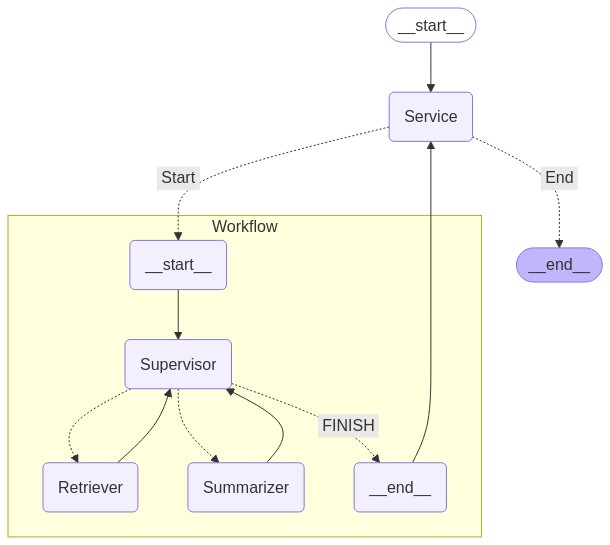

In [24]:
from IPython.display import Image, display

display(Image(service_graph.get_graph(xray=3).draw_mermaid_png()))

### Invoke

In [25]:
# 請給我教務處的最新消息
# 請給我教務長的姓名
# 請總結111教務章則的內容
query = "請給我教務處的最新消息"
user_id = "12345"

thread_id = user_id
input_messages = {"messages": [HumanMessage(content=query)]}
config = {
    "recursion_limit": 100, # agent彼此間的最大交互次數
    "configurable": {
        "thread_id": "service" + thread_id # 用來存取記憶的id
    }
}

for chunk in service_graph.stream(input=input_messages, config=config, subgraphs=True, stream_mode="values"):
    chunk[1]["messages"][-1].pretty_print()

================================ Human Message =================================

請給我教務處的最新消息
================================ Human Message =================================

請給我教務處的最新消息
================================== Ai Message ==================================
Tool Calls:
  none (call_ujM0iJBuMMLLB8sbFKBlxxQ6)
 Call ID: call_ujM0iJBuMMLLB8sbFKBlxxQ6
  Args:
================================= Tool Message =================================
Name: none

null
================================== Ai Message ==================================

START Workflow. 請給我教務處的最新消息
================================ Human Message =================================
Name: Service

START Workflow. 請給我教務處的最新消息

workflow_graph_input: 
{'messages': [HumanMessage(content='請給我教務處的最新消息', additional_kwargs={}, response_metadata={}, id='0ec9c878-0fdb-4175-ad6e-028d13697158'), HumanMessage(content='START Workflow. 請給我教務處的最新消息', additional_kwargs={}, response_metadata={}, name='Service')]}
Thread id:  workflow1234

In [24]:
def service_chat(query: str, user_id: str):
    response_messages = []
    input_messages = [HumanMessage(content=query)]
    thread_id = f"service{user_id}"

    for chunk in service_graph.stream(
        input={"messages": input_messages, "user_id": user_id},
        config={"recursion_limit": 50, "configurable": {"thread_id": thread_id}},
        subgraphs=True,
        stream_mode="updates"
    ):
        
        # chunk[1]["messages"][-1].pretty_print()
        response_messages.append(chunk[1])

    # 幫我從字串有以下內容抓取資料 screenshot: [screenshot file name]
    # screenshot_filename = ""
    # # 先幫我檢查最後一個訊息是否有包含 screenshot: 字串
    # if "screenshot: " in response_messages[-1]['Pipeline Runner']['messages'][-1].content:
    #     screenshot_filename = response_messages[-1]['Pipeline Runner']['messages'][-1].content.split("screenshot: ")[1]
    #     screenshot_filename = screenshot_filename.split(".png")[0] + ".png"
    print(response_messages[-1]['Service']['messages'][-1].content)
    # print(screenshot_filename)
    # Return the combined response messages
    # return screenshot_filename, response_messages[-1]['Pipeline Runner']['messages'][-1].content
    return response_messages[-1]['Service']['messages'][-1].content

def respond(message, chat_history):
    user_id = "101112"
    chat_history.append({"role": "user", "content": message})
    bot_message = service_chat(message, user_id)
    chat_history.append({"role": "assistant", "content": bot_message})

    return "", chat_history

In [25]:
import gradio as gr

with gr.Blocks() as demo:
    chatbot = gr.Chatbot(type="messages")
    msg = gr.Textbox()
    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch()

c:\Users\George\anaconda3\envs\langgraph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.



workflow_graph_input: 
{'messages': [HumanMessage(content='請簡介111教務章則', additional_kwargs={}, response_metadata={}, id='e467947b-0280-4849-bd73-6aa665c6b1ba'), HumanMessage(content='START Workflow. 請簡介111教務章則', additional_kwargs={}, response_metadata={}, name='Service')]}
Thread id:  workflow123456789

retreirver_graph_input: 
{'messages': [HumanMessage(content='START Workflow. 請簡介111教務章則', additional_kwargs={}, response_metadata={}, name='Service')]}
Thread id:  retriever123456789
link:  https://pdc.adm.ncu.edu.tw/rule/rule111/index.html
page_content:  網站標題: 111教務章則彙編
簡介: 111學年度國立中央大學教務章則彙編目錄列出了多項與學生學業、選課及學籍管理相關的規定及辦法。主要內容包含：

1. 學則及學生選課辦法
2. 校際選課及暑期開班授課規定
3. 學生轉系、雙主修、輔系等修讀辦法
4. 學分學程及必修科目要求
5. 碩博士研究生的學位考試及進修相關規定
6. 學生成績及考試規則
7. 學術倫理及違規處理原則
8. 離校退費及自主學習課程的相關規定

整體而言，這些章則提供了學生在學習過程中所需遵循的規範，以確保學業順利進行。
---
link:  https://pdc.adm.ncu.edu.tw/rule/rule111/index.html
page_content:  網站標題: 111教務章則彙編
簡介: 111學年度國立中央大學教務章則彙編目錄列出了多項與學生學業、選課及學籍管理相關的規定及辦法。主要內容包含：

1. 學則及學生選課辦法
2. 校際選課及暑期開班授課規定
3. 學生

# Pipeline Creator Graph

## Create Pipeline Creator

In [ ]:
import functools
from langgraph.prebuilt import create_react_agent

# Pipeline Creator
tools = [all_tools[name] for name in agents_parameter['pipeline_creator']['tools']]
system_message = agents_parameter['pipeline_creator']['system_message']
pipeline_creator = create_react_agent(llm, tools=tools, state_modifier=functools.partial(modify_state_messages, tools=tools, system_message=system_message))
pipeline_creator_node = functools.partial(pipeline_agent_node, agent=pipeline_creator, name="Pipeline_Creator")

## Define Pipeline Creator Graph

In [ ]:
from langgraph.graph import StateGraph
from langgraph.graph import END, START
from langgraph.checkpoint.memory import MemorySaver

pipeline_creator_ = StateGraph(AgentState)
pipeline_creator_.add_node("Pipeline Creator", pipeline_creator_node)

pipeline_creator_.add_edge(START, "Pipeline Creator")
pipeline_creator_.add_edge("Pipeline Creator", END)

pipeline_creator_memory = MemorySaver()
pipeline_creator_graph = pipeline_creator_.compile(checkpointer=pipeline_creator_memory)

In [ ]:
# from IPython.display import Image, display

# display(Image(pipeline_creator_graph.get_graph(xray=1).draw_mermaid_png()))

### Invoke

In [ ]:
import shutil

screenshots_dir = "screenshots"
if os.path.exists(screenshots_dir):
    for filename in os.listdir(screenshots_dir):
        file_path = os.path.join(screenshots_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
print("Cleared screenshots directory")

In [ ]:
def pipeline_creator_chat(query: str, user_id: str):
    thread_id = user_id
    input_messages = {"messages": [HumanMessage(content=query)], "user_id": user_id}  
    config = {
        "recursion_limit": 50, # agent彼此間的最大交互次數
        "configurable": {
            "thread_id": "pipeline creator" + thread_id # 用來存取記憶的id
        }
    }

    for chunk in pipeline_creator_graph.stream(input=input_messages, config=config, subgraphs=True, stream_mode="values"):
        chunk[1]["messages"][-1].pretty_print()

In [ ]:
user_id = "101112"

In [ ]:
query = "請打開瀏覽器後到 https://cis.ncu.edu.tw/iNCU/stdAffair/leaveRequest 頁面"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "幫我輸入帳號"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "幫我輸入密碼"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我點擊登入按鈕"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我點擊 go to 按鈕"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我點擊申請按鈕"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我勾選'本人已詳讀並充分了解 '"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我點擊送出按鈕"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我在下拉選單中選取[病假]"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我點擊請假開始日的輸入框"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我點擊第1個日曆中的[2024年11月26日], 具體日期文字請以網頁html內容為主"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我點擊請假結束日的輸入框"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "index = 2, 請幫我點擊第2個日曆中的[2024年11月27日], 具體日期文字請以網頁html內容為主"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我點擊送出"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我在請假事由的輸入框內填入[生病]"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我上傳以下檔案[C:\\Users\\George\\Pictures\\Screenshots\\螢幕擷取畫面 2024-11-24 212903.png]到confirm_file"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我點擊is_check選取框"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請幫我點擊暫存"
pipeline_creator_chat(query, user_id)

In [ ]:
query = "請總結目前執行過的步驟"
pipeline_creator_chat(query, user_id)

In [ ]:
del selenium_controller